# Set environment

In [1]:
import os, sys
from pathlib import Path

main_folder = str(Path.cwd().parent)
sys.path.append(main_folder)

import warnings
warnings.filterwarnings("ignore")

# Load data

In [2]:
from src.data.data_loader import *

maturity = 63                         # Maturities: {21,63,126} 
isput = False                          # Put or Call: {True,False}
moneyness = "ATM"                     # Moneyness options: {"ATM","ITM","OTM"}
prepro_stock = "Log"                  # Price preprocessing {Log, Log-moneyness, Nothing}
backtest = False                      # Backtest only includes inference procedure for real data
sigma = None                          # Input value for GBM simulation 

# 0) Default parameters 
S_0         = 100                     # Initial stock price
r           = 0.026623194             # Annualized continuous risk-free rate
q           = 0.01772245              # Annualized continuous dividend yield

option, n_timesteps, paths, paths_valid, disc_batch, dividend_batch, V_0, V_test, strike = training_variables(maturity,moneyness,isput,prepro_stock,backtest,r,q,sigma)


# Fit Deep agent

-------------------------------------------------------------
RNNFNN_Reduced_2_dropout_50_CVaR_95_TC_0_Call_ATM_NoCashC
-------------------------------------------------------------
---Training start---


2024-04-12 22:59:27.290437: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled


Saved
Time elapsed: 0:02:38.194512
Epoch 1, CVaR, Train: 6.824 Valid: 5.935
Saved
Time elapsed: 0:05:14.191470
Epoch 2, CVaR, Train: 5.660 Valid: 5.466
Saved
Time elapsed: 0:07:54.132874
Epoch 3, CVaR, Train: 4.611 Valid: 3.535
---Finished training results---
Time elapsed: 0:07:54.132898
---Training end---


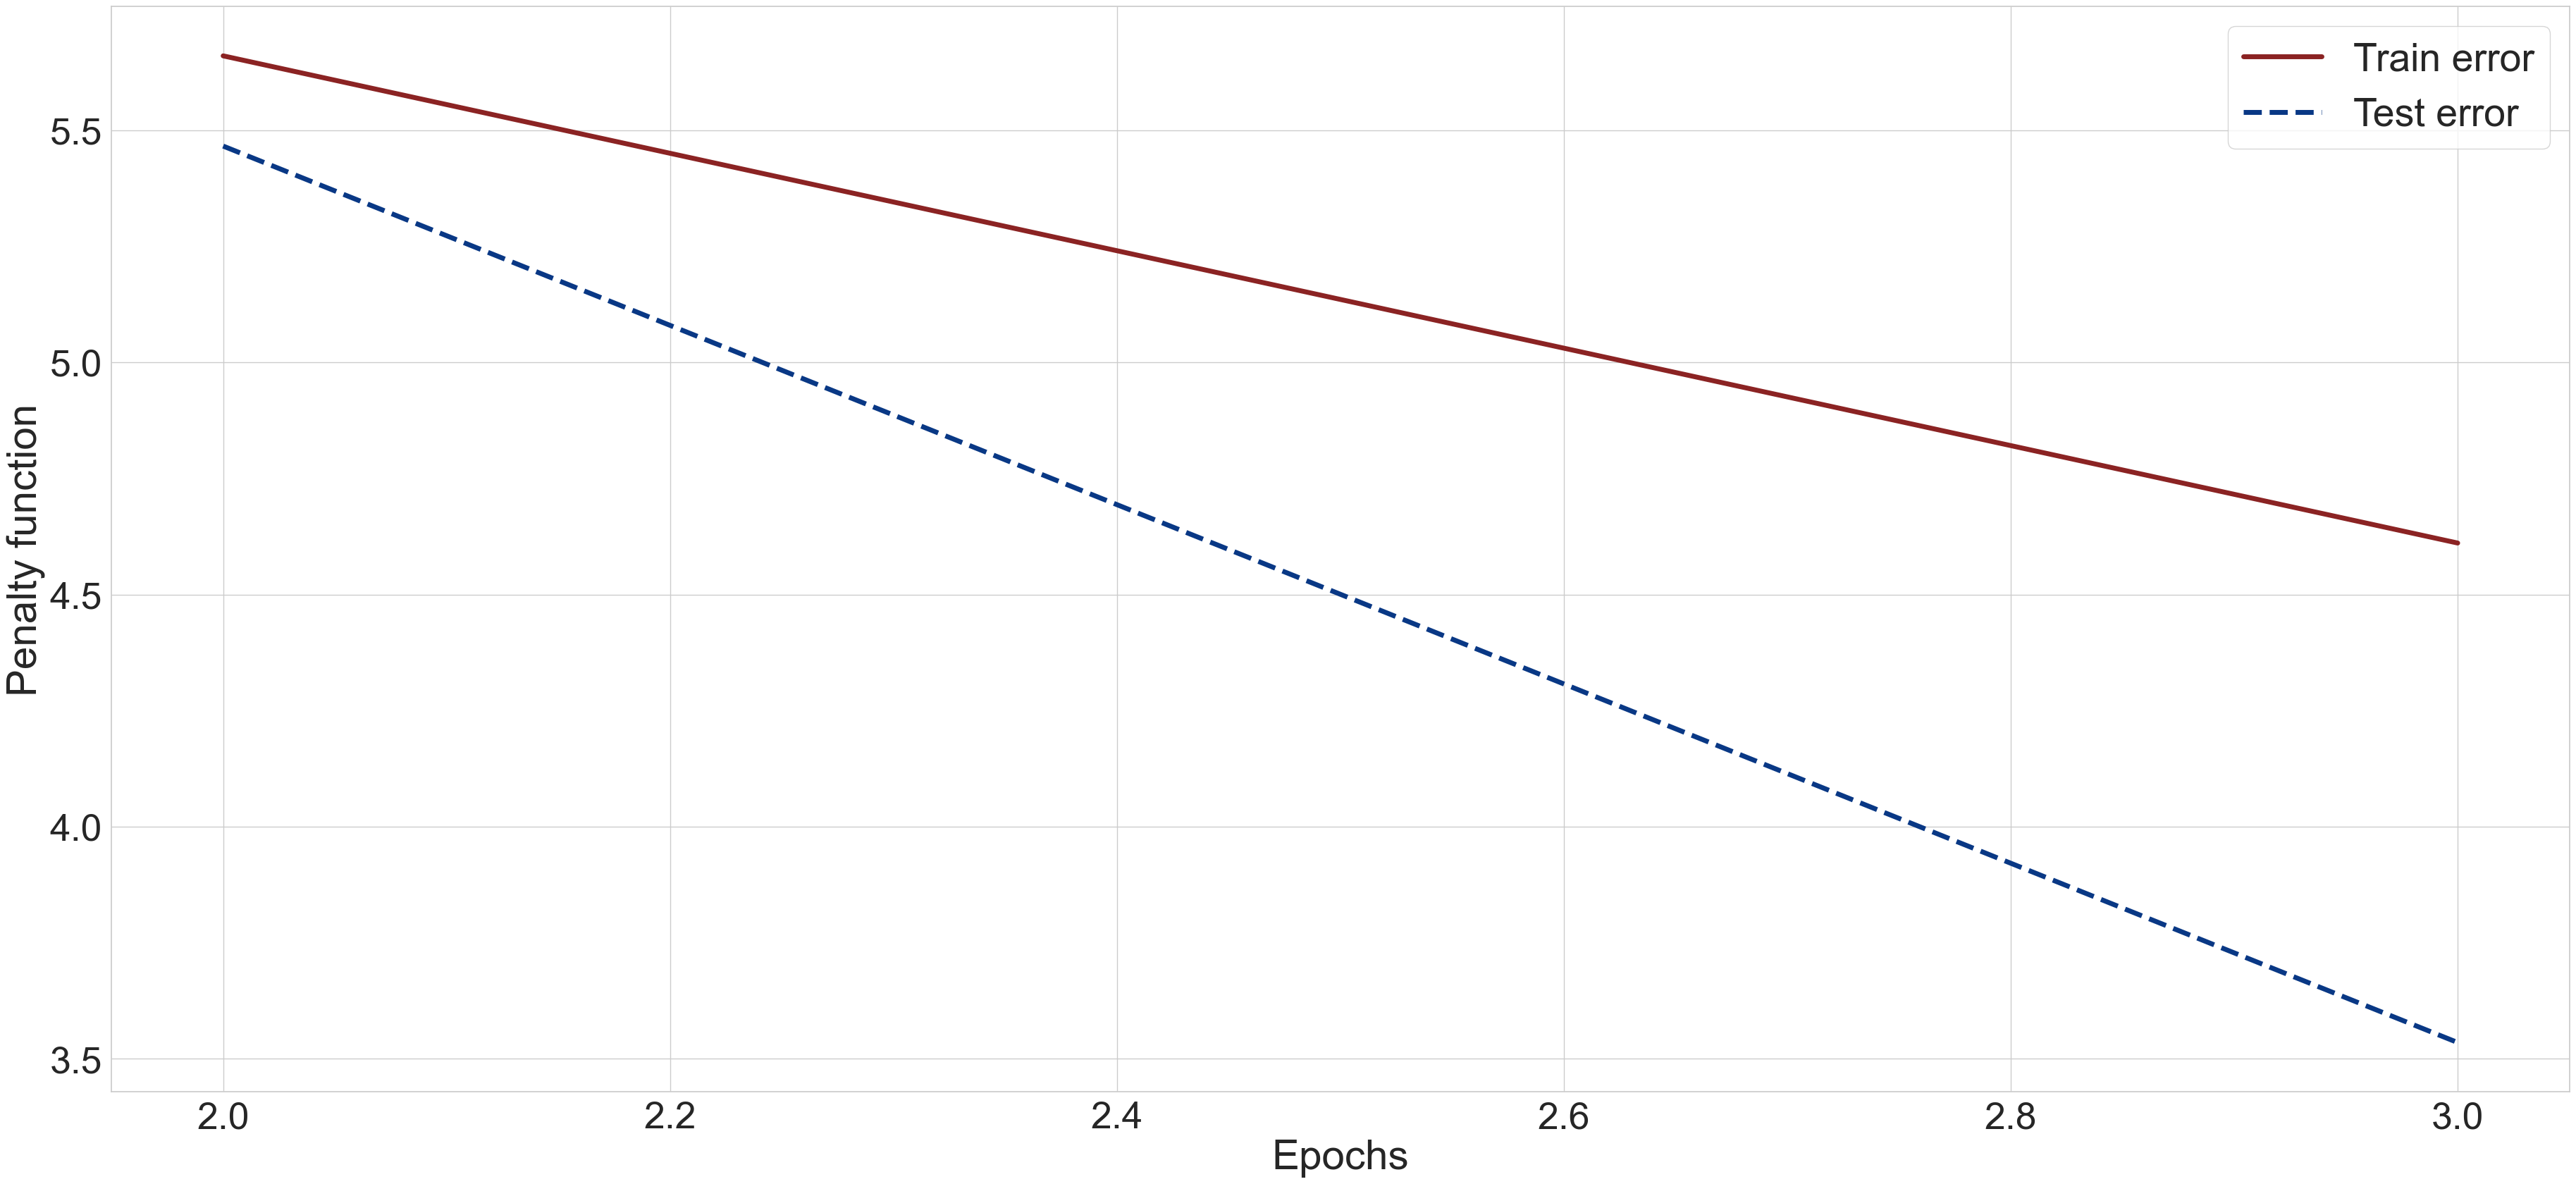

In [3]:
# First layer of parameters 
network         = "RNNFNN"             # Neural network architecture {"LSTM","RNNFNN","FFNN"}
state_space     = "Reduced_2"               # State space considered in the RL framework {"Full","Reduced_1","Reduced_2"}
cash_constraint = False                # Boolean variable to include cash constraints {True,False}
constraint_max  = 100                  # Cash constraint limit (positive number)
nbs_point_traj  = paths.shape[0]       # time steps 
batch_size      = 1000                 # batch size {296,1000} 
nbs_input       = paths.shape[2]       # number of features
nbs_units       = 56                   # neurons per layer/cell
nbs_assets      = 1                    # number of hedging intruments
loss_type       = "CVaR"               # loss function {"CVaR","MSE","SMSE"}
lr              = 0.0005               # learning rate of the Adam optimizer
dropout_par     = 0.5                  # dropout regularization parameter 

# Second layer of parameters
paths           = paths                # Training set (normalized stock price and features)
V_0             = V_0                  # Initial portfolio value for training set
V_test          = V_test               # Initial portfolio value for validation set
strikes         = strike               # Strike value of the option hedged 
disc_batch      = disc_batch           # Risk-free rate update factor exp(h*r)
dividend_batch  = dividend_batch       # Dividend yield update factor exp(h*d)
transaction_cost = 0                   # Proportional transaction cost [0,5/10000,5/1000,1/100]
riskaversion    = 0.95                 # CVaR confidence level (0,1)
paths_valid     = paths_valid          # Validation set (normalized stock price and features)
epochs          = 3                    # Number of epochs, training iterations 

# Third layer of parameters
display_plot    = True                 # Display plot of training and validation loss

#Train the network
from src.models.DeepRL_agent import train_network

loss_train_epoch = train_network(network, state_space, nbs_point_traj, batch_size, nbs_input, nbs_units, nbs_assets, cash_constraint, constraint_max, loss_type, lr, dropout_par, paths, V_0, V_test, strikes, disc_batch,
dividend_batch, transaction_cost, riskaversion, paths_valid, epochs, display_plot, option, moneyness, isput, prepro_stock)

## Retrain network

-------------------------------------------------------------
RNNFNN_Reduced_2_dropout_50_CVaR_95_TC_0_Call_ATM_NoCashC
-------------------------------------------------------------
---Training start---
INFO:tensorflow:Restoring parameters from RNNFNN_Reduced_2_dropout_50_CVaR_95_TC_0_Call_ATM_NoCashC.ckpt
Saved
Time elapsed: 0:02:46.339377
Epoch 1, CVaR, Train: 3.220 Valid: 3.029
Saved
Time elapsed: 0:05:30.086018
Epoch 2, CVaR, Train: 2.792 Valid: 2.593
Saved
Time elapsed: 0:08:13.715154
Epoch 3, CVaR, Train: 2.494 Valid: 2.326
---Finished training results---
Time elapsed: 0:08:13.715181
---Training end---


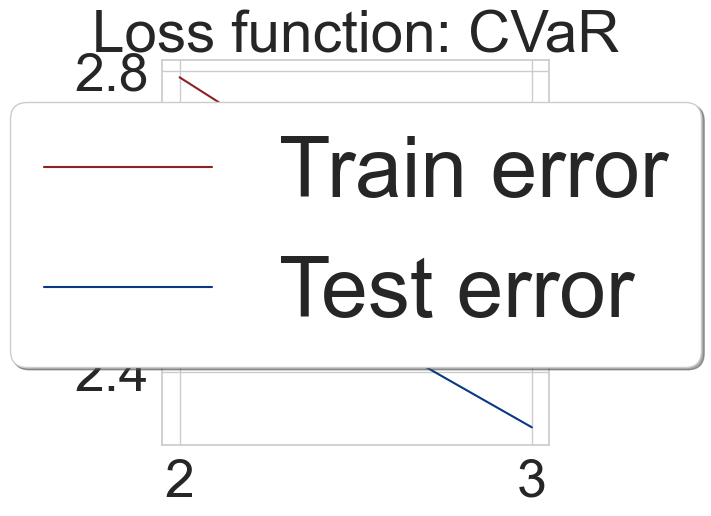

In [4]:
# First layer of parameters 
network         = "RNNFNN"             # Neural network architecture {"LSTM","RNNFNN","FFNN"}
state_space     = "Reduced_2"               # State space considered in the RL framework {"Full","Reduced_1","Reduced_2"}
cash_constraint = False                # Boolean variable to include cash constraints {True,False}
constraint_max  = 100                  # Cash constraint limit (positive number)
nbs_point_traj  = paths.shape[0]       # time steps 
batch_size      = 1000                 # batch size {296,1000} 
nbs_input       = paths.shape[2]       # number of features
nbs_units       = 56                   # neurons per layer/cell
nbs_assets      = 1                    # number of hedging intruments
loss_type       = "CVaR"               # loss function {"CVaR","MSE","SMSE"}
lr              = 0.0005               # learning rate of the Adam optimizer
dropout_par     = 0.5                  # dropout regularization parameter 

# Second layer of parameters
paths           = paths                # Training set (normalized stock price and features)
V_0             = V_0                  # Initial portfolio value for training set
V_test          = V_test               # Initial portfolio value for validation set
strikes         = strike               # Strike value of the option hedged 
disc_batch      = disc_batch           # Risk-free rate update factor exp(h*r)
dividend_batch  = dividend_batch       # Dividend yield update factor exp(h*d)
transaction_cost = 0                   # Proportional transaction cost [0,5/10000,5/1000,1/100]
riskaversion    = 0.95                 # CVaR confidence level (0,1)
paths_valid     = paths_valid          # Validation set (normalized stock price and features)
epochs          = 3                    # Number of epochs, training iterations 

# Third layer of parameters
display_plot    = True                # Display plot of training and validation loss

#Train the network
from src.models.DeepRL_agent import retrain_network

loss_train_epoch = retrain_network(network, state_space, nbs_point_traj, batch_size, nbs_input, nbs_units, nbs_assets, cash_constraint, constraint_max, loss_type, lr, dropout_par, paths, V_0, V_test, strikes, disc_batch,
dividend_batch, transaction_cost, riskaversion, paths_valid, epochs, display_plot, option, moneyness, isput, prepro_stock)

## Test network

In [3]:
# First layer of parameters 
network         = "RNNFNN"             # Neural network architecture {"LSTM","RNNFNN","FFNN"}
state_space     = "Reduced_2"          # State space considered in the RL framework {"Full","Reduced_1","Reduced_2"}
cash_constraint = False                # Boolean variable to include cash constraints 
constraint_max  = 100                  # Cash constraint limit
nbs_point_traj  = paths.shape[0]       # time steps 
batch_size      = 1000                 # batch size {296,1000}
nbs_input       = paths.shape[2]       # number of features
nbs_units       = 56                   # neurons per layer/cell
nbs_assets      = 1                    # number of hedging intruments
loss_type       = "CVaR"                # loss function {"CVaR","MSE","SMSE"}
lr              = 0.0005               # learning rate of the Adam optimizer
dropout_par     = 0.5                  # dropout regularization parameter 

# Second layer of parameters
paths           = paths                # Training set (normalized stock price and features)
V_0             = V_0                  # Initial portfolio value for training set
V_test          = V_test               # Initial portfolio value for validation set
strikes         = strike               # Strike value of the option hedged 
disc_batch      = disc_batch           # Risk-free rate update factor exp(h*r)
dividend_batch  = dividend_batch       # Dividend yield update factor exp(h*d)
transaction_cost = 0                   # Proportional transaction cost [0,5/10000,5/1000,1/100]
riskaversion    = 0.95                 # CVaR confidence level (0,1)
paths_valid     = paths_valid          # Validation set (normalized stock price and features)
epochs          = 50                   # Number of epochs, training iterations 

# Third layer of parameters
display_plot    = True                 # Display plot of training and validation loss

#Train the network
from src.models.DeepRL_agent import network_inference

deltas = network_inference(network, state_space, nbs_point_traj, batch_size, nbs_input, nbs_units, nbs_assets, cash_constraint, constraint_max, loss_type, lr, dropout_par, V_test, strikes, disc_batch,
dividend_batch, transaction_cost, riskaversion, paths_valid, option, moneyness, isput, prepro_stock, backtest)

-------------------------------------------------------------
RNNFNN_Reduced_2_dropout_50_CVaR_95_TC_0_Call_ATM_NoCashC
-------------------------------------------------------------
---Inference start---
INFO:tensorflow:Restoring parameters from RNNFNN_Reduced_2_dropout_50_CVaR_95_TC_0_Call_ATM_NoCashC.ckpt


2024-04-12 23:36:49.684390: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled


---Inference end---


In [5]:
### With V
from src.visualization.Strategy_evaluation import hedging_valuation
close_limit_days = 0
hedging_portfolio_2, hedging_error_2, hedging_error_limit_2, cost_limit, option_price_2, df_statistic_TC, df_cost_functions = hedging_valuation(backtest, strikes, deltas, transaction_cost, isput, close_limit_days, r, q, sigma)
#df_cost_functions.to_csv("Results.csv")
df_cost_functions

,Mean-HE,CVaR_95%,CVaR_99%,MSE,SMSE
0,-0.452506,2.326804,3.814278,17.616336,0.760514


## Multiple training

### Multiple training

In [6]:
from src.data.data_loader import *

for maturity in [63]:                             # Maturities: {21,63,126}

    list_option = [False] if maturity==63 else [False]
    list_moneyness = ["ATM"] #["ATM","ITM","OTM"] if maturity==63 else ["ATM"]

    for isput in list_option:                    # Put or Call: {True,False}
        
        for moneyness in ["ATM"]:     # Moneyness options: {"ATM","ITM","OTM"}
            prepro_stock = "Log"                  # Price preprocessing {Log, Log-moneyness, Nothing}
            backtest = False                      # Backtest only includes inference procedure for real data

            # 0) Default parameters 
            S_0         = 100                     # Initial stock price
            r           = 0.009713920000000001    # Annualized continuous risk-free rate
            q           = 0.01543706              # Annualized continuous dividend yield

            option, n_timesteps, paths, paths_valid, disc_batch, dividend_batch, V_0, V_test, strike = training_variables(maturity,moneyness,isput,prepro_stock,backtest)


            # First layer of parameters 
            network         = "RNNFNN"             # Neural network architecture {"LSTM","RNNFNN","FFNN"}
            nbs_point_traj  = paths.shape[0]       # time steps 
            batch_size      = 1000                 # batch size {296,1000}
            nbs_input       = paths.shape[2]       # number of features
            nbs_units       = 56                   # neurons per layer/cell
            nbs_assets      = 1                    # number of hedging intruments
            constraint_min  = 0                    # lower bound for position in hedging instruments
            constraint_max  = -100                 # upper bound for position in hedging instruments

            for dropout_par in [0.5]:              # dropout regularization parameter

                if moneyness == "ATM":
                    transaction_range = [1/100] if maturity==63 else [5/10000] #[0,5/10000,5/1000,1/100]
                else:
                    transaction_range =  [0]

                for transaction_cost in transaction_range:

                    idx = 0
                    for loss_type in ["CVaR","SMSE"]:
                        if idx == 0:
                            riskaversion    = 0.95             # CVaR confidence level (0,1)
                            idx += 1
                        else:
                            riskaversion    = 0.99

                        lr              = 0.0005               # learning rate of the Adam optimizer
                        # Second layer of parameters
                        paths           = paths                # Training set (normalized stock price and features)
                        V_0             = V_0                  # Initial portfolio value for training set
                        V_test          = V_test               # Initial portfolio value for validation set
                        strikes         = strike               # Strike value of the option hedged 
                        disc_batch      = disc_batch           # Risk-free rate update factor exp(h*r)
                        dividend_batch  = dividend_batch       # Dividend yield update factor exp(h*d)

                              
                        paths_valid     = paths_valid      # Validation set (normalized stock price and features)
                        epochs          = 3                # Number of epochs, training iterations 

                        # Third layer of parameters
                        display_plot    = False            # Display plot of training and validation loss

                        #Train the network
                        from src.models.Deep_agent_withoutV_CashConstraint_position import retrain_network #train_network

                        loss_train_epoch = retrain_network(network, nbs_point_traj, batch_size, nbs_input, nbs_units, nbs_assets, constraint_min, constraint_max, loss_type, lr, dropout_par, paths, V_0, V_test, strikes, disc_batch,
                                            dividend_batch, transaction_cost, riskaversion, paths_valid, epochs, display_plot, option, moneyness, isput, prepro_stock)

-------------------------------------------------------------
RNNFNN_dropout_50_CVaR_95_TC_1.0_Call_ATM_cons_-100
-------------------------------------------------------------
---Training start---
INFO:tensorflow:Restoring parameters from RNNFNN_dropout_50_CVaR_95_TC_1.0_Call_ATM_cons_-100.ckpt
Saved
Time elapsed: 0:02:52.684833
Epoch 1, CVaR, Train: 3.531 Valid: 3.416
Saved
Time elapsed: 0:05:30.014257
Epoch 2, CVaR, Train: 3.543 Valid: 3.387
Time elapsed: 0:08:05.428929
Epoch 3, CVaR, Train: 3.496 Valid: 3.414
---Finished training results---
Time elapsed: 0:08:05.429020
---Training end---
-------------------------------------------------------------
RNNFNN_dropout_50_SMSE_TC_1.0_Call_ATM_cons_-100
-------------------------------------------------------------
---Training start---
INFO:tensorflow:Restoring parameters from RNNFNN_dropout_50_SMSE_TC_1.0_Call_ATM_cons_-100.ckpt
Saved
Time elapsed: 0:02:53.225346
Epoch 1, SMSE, Train: 1.752 Valid: 1.704
Saved
Time elapsed: 0:05:34.279555
E

### Multiple inference

In [2]:
from src.data.data_loader import *
from src.models.Deep_agent_withoutV_CashConstraint import network_inference
from src.visualization.Strategy_evaluation import hedging_valuation
import pandas as pd

df_results = pd.DataFrame()
close_limit_days = 0
for maturity in [63]:                                        # Maturities: {21,63,126}

    list_option = [False] if maturity==63 else [False]
    list_moneyness = ["ATM"] if maturity==63 else ["ATM"]

    for isput in list_option:                                    # Put or Call: {True,False}
        
        for moneyness in list_moneyness:                         # Moneyness options: {"ATM","ITM","OTM"}
            prepro_stock = "Log"                                 # Price preprocessing {Log, Log-moneyness, Nothing}
            backtest = False                                     # Backtest only includes inference procedure for real data

            # 0) Default parameters 
            S_0         = 100                                    # Initial stock price
            r           = 0.009713920000000001                   # Annualized continuous risk-free rate
            q           = 0.01543706                             # Annualized continuous dividend yield

            option, n_timesteps, paths, paths_valid, disc_batch, dividend_batch, V_0, V_test, strike = training_variables(maturity,moneyness,isput,prepro_stock,backtest)

            # First layer of parameters 
            for network in ["RNNFNN"]:   # Neural network architecture {"LSTM","RNNFNN","FFNN"}
                nbs_point_traj  = paths_valid.shape[0]                # time steps 
                batch_size      = 1000 if backtest != True else 296   # batch size {296,1000}
                nbs_input       = paths_valid.shape[2]                # number of features
                nbs_units       = 56                                  # neurons per layer/cell
                nbs_assets      = 1                                   # number of hedging intruments
                constraint_min  = -5                                  # lower bound for position in hedging instruments
                constraint_max  = -100                                # upper bound for position in hedging instruments
                            
                for dropout_par in [0.5]:                             # dropout regularization parameter

                    if moneyness == "ATM":
                        transaction_range = [0] if maturity==63 else [0] #[0,5/10000,5/1000,1/100]
                    else:
                        transaction_range =  [0]

                    for transaction_cost in transaction_range:    # Proportional transaction cost [0,1]  

                        idx = 0
                        for loss_type in ["CVaR","CVaR","MSE","SMSE"]:    # loss function {"CVaR","MSE","SMSE" ["CVaR","CVaR","MSE","SMSE"]
                            lr              = 0.0005                      # learning rate of the Adam optimizer
                            
                            # Second layer of parameters
                            paths           = paths                           # Training set (normalized stock price and features)
                            V_0             = V_0                             # Initial portfolio value for training set
                            V_test          = V_test                          # Initial portfolio value for validation set
                            strikes         = strike                          # Strike value of the option hedged 
                            disc_batch      = disc_batch                      # Risk-free rate update factor exp(h*r)
                            dividend_batch  = dividend_batch                  # Dividend yield update factor exp(h*d)
                            if idx == 0:
                                riskaversion    = 0.95                    # CVaR confidence level (0,1)
                                idx += 1
                            else:
                                riskaversion    = 0.99                    # CVaR confidence level (0,1)
                            paths_valid     = paths_valid                 # Validation set (normalized stock price and features)
                            epochs          = 50                          # Number of epochs, training iterations 

                            # Third layer of parameters
                            display_plot    = False
                                
                            #Network inference
                            deltas = network_inference(network, nbs_point_traj, batch_size, nbs_input, nbs_units, nbs_assets, constraint_min, constraint_max, loss_type, lr, dropout_par, V_test, strikes, disc_batch,
                            dividend_batch, transaction_cost, riskaversion, paths_valid, option, moneyness, isput, prepro_stock, backtest)

                            #Test result
                            hedging_portfolio, hedging_error, hedging_error_limit, cost_limit, option_price, df_statistic_TC, df_cost_functions = hedging_valuation(backtest, strikes, deltas, transaction_cost, isput, close_limit_days)
                            df_results = pd.concat([df_results,df_cost_functions])


-------------------------------------------------------------
RNNFNN_dropout_50_CVaR_95_TC_0_Call_ATM_cons_-100
-------------------------------------------------------------
---Inference start---
INFO:tensorflow:Restoring parameters from RNNFNN_dropout_50_CVaR_95_TC_0_Call_ATM_cons_-100.ckpt


2024-03-26 12:15:47.983070: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled


---Inference end---
-------------------------------------------------------------
RNNFNN_dropout_50_CVaR_99_TC_0_Call_ATM_cons_-100
-------------------------------------------------------------
---Inference start---
INFO:tensorflow:Restoring parameters from RNNFNN_dropout_50_CVaR_99_TC_0_Call_ATM_cons_-100.ckpt
---Inference end---
-------------------------------------------------------------
RNNFNN_dropout_50_MSE_TC_0_Call_ATM_cons_-100
-------------------------------------------------------------
---Inference start---
INFO:tensorflow:Restoring parameters from RNNFNN_dropout_50_MSE_TC_0_Call_ATM_cons_-100.ckpt
---Inference end---
-------------------------------------------------------------
RNNFNN_dropout_50_SMSE_TC_0_Call_ATM_cons_-100
-------------------------------------------------------------
---Inference start---
INFO:tensorflow:Restoring parameters from RNNFNN_dropout_50_SMSE_TC_0_Call_ATM_cons_-100.ckpt
---Inference end---


In [9]:
#df_results.to_csv("Results_tc_position.csv")

In [4]:
df_results

,Mean-HE,CVaR_95%,CVaR_99%,MSE,SMSE
0,-0.402993,1.724209,3.013200,2.028539,0.279844
0,-0.362350,1.824076,2.941826,2.314383,0.334442
0,-0.321332,2.019133,3.599060,0.963429,0.324586
0,-0.385512,1.802699,3.181414,1.168127,0.265277


## SAGE values

In [6]:
from src.data.data_loader import *
import pandas as pd

directory = os.path.join(main_folder,'data','results','SAGE')

maturity = 63                             # Maturities: {21,63,126} 
for isput in [False]:                     # Put or Call: {True,False}
    for moneyness in ["ATM","ITM","OTM"]: # Moneyness options: {"ATM","ITM","OTM"}
        prepro_stock = "Log"                  # Price preprocessing {Log, Log-moneyness, Nothing}
        backtest = False                      # Backtest only includes inference procedure for real data
        sigma = None                          # Input value for GBM simulation 

        # 0) Default parameters 
        S_0         = 100                     # Initial stock price
        r           = 0.026623194             # Annualized continuous risk-free rate
        q           = 0.01772245              # Annualized continuous dividend yield

        option, n_timesteps, paths, paths_valid, disc_batch, dividend_batch, V_0, V_test, strike = training_variables(maturity,moneyness,isput,prepro_stock,backtest,r,q,sigma)

        # First layer of parameters 
        network         = "RNNFNN"             # Neural network architecture {"LSTM","RNNFNN","FFNN"}
        state_space     = "Reduced_2"          # State space considered in the RL framework {"Full","Reduced_1","Reduced_2"}
        cash_constraint  = True                # lower bound for position in hedging instruments
        constraint_max  = 100                  # upper bound for position in hedging instruments 
        nbs_point_traj  = paths.shape[0]       # time steps 
        batch_size      = 1000                 # batch size {296,1000}
        nbs_input       = paths.shape[2]       # number of features
        nbs_units       = 56                   # neurons per layer/cell
        nbs_assets      = 1                    # number of hedging intruments             

        idx = 0
        for loss_type in ["CVaR","CVaR","MSE","SMSE"]:    # loss function ["CVaR","CVaR","MSE","SMSE"]
            if idx == 0:
                riskaversion    = 0.95                    # CVaR confidence level (0,1)
                idx += 1
            else:
                riskaversion    = 0.99
            lr              = 0.0005               # learning rate of the Adam optimizer
            dropout_par     = 0.5                  # dropout regularization parameter 

            # Second layer of parameters
            paths           = paths                # Training set (normalized stock price and features)
            V_0             = V_0                  # Initial portfolio value for training set
            V_test          = V_test               # Initial portfolio value for validation set
            strikes         = strike               # Strike value of the option hedged 
            disc_batch      = disc_batch           # Risk-free rate update factor exp(h*r)
            dividend_batch  = dividend_batch       # Dividend yield update factor exp(h*d)
            transaction_cost = 0                   # Proportional transaction cost [0,1]
            paths_valid     = paths_valid          # Validation set (normalized stock price and features)
            epochs          = 10                   # Number of epochs, training iterations 

            # Third layer of parameters
            display_plot    = True                 # Display plot of training and validation loss

            #Train the network

            option_name = "Call" if isput==False else "Put"
            print(option_name + '_' + moneyness + '_' + str(maturity)  + '_' + loss_type + '_' + str(int(riskaversion*100)))
            
            from src.models.DeepRL_agent import sage_network
            loss_train_epoch = sage_network(network, state_space, nbs_point_traj, batch_size, nbs_input, nbs_units, nbs_assets, cash_constraint, constraint_max, loss_type, lr, dropout_par, paths, V_0, V_test, strikes, disc_batch,
            dividend_batch, transaction_cost, riskaversion, paths_valid, epochs, display_plot, option, moneyness, isput, prepro_stock)

            #Save SAGE
            loss_name = loss_type + '_' + str(int(riskaversion*100)) if loss_type == "CVaR" else loss_type
            name = option_name + '_' + moneyness + '_' + str(maturity)  + '_' + loss_name + '_' + '_SAGE.csv' # 
            pd.DataFrame(loss_train_epoch).to_csv(os.path.join(directory,name))

Call_ATM_63_CVaR_95
---------------------------------------------------------------------
- SAGE values - RNNFNN_Reduced_2_dropout_50_CVaR_95_TC_0_Call_ATM_CashC_100 --
---------------------------------------------------------------------
-------- Case 0 out of 64 --------
